<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

[6. Baseline Modeling 2.0](#6)

[7. Baseline Modeling 3.0](#7)

[8. Baseline Modeling 4.0](#8)

[9. Ensemble Modeling ](#9)

[10. Baseline Modeling 5.0](#10)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

- Version 1 (11/13/2023)
    * EDA 
    * Baseline modeling 1.0.
    

- Version 2 (11/14/2023)
    * Baseline modeling 1.0 models were updated.
    
    
- Version 3 (11/14/2023)
    * Baseline modeling 1.0 models were updated.
    
    
- Version 4 (11/16/2023)
    * Baseline modeling 2.0 added.
    
    
- Version 5 (11/19/2023)
    * Baseline modeling 2.0 updated.
    
    
- Version 6 (11/20/2023)
    * Baseline modeling 2.0 updated (median stacker)
    
    
- Version 7 (11/23/2023)
    * Baseline modeling 3.0 added.
    * Ensemble modeling added.
    
    
- Version 8 (11/24/2023)
    * Baseline modeling 1.0 ensemble updated.
    
    
- Version 9 (11/27/2023)
    * Baseline modeling 4.0 added.
    * Ensemble modeling updated.
    
    
- Version 10 (11/28/2023)
    * Baseline modeling 5.0 added.
    
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
!pip install scikit-lego

  Obtaining dependency information for scikit-lego from https://files.pythonhosted.org/packages/ee/c7/59d85703bfcee1bed406f0cb4bcb10871e5327ba333ff0557d3a100014bc/scikit_lego-0.6.16-py2.py3-none-any.whl.metadata
  Obtaining dependency information for autograd>=1.2 from https://files.pythonhosted.org/packages/81/70/d5c7c2a458b8be96495c8b1634c2155beab58cbe864b7a9a5c06c2e52520/autograd-1.6.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.4 MB/s eta 0:00:00


In [2]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, median_absolute_error, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [3]:
train = pd.read_csv('../input/playground-series-s3e25/train.csv')
test = pd.read_csv('../input/playground-series-s3e25/test.csv')
submission = pd.read_csv('../input/playground-series-s3e25/sample_submission.csv')

print(f"The dimension of the train dataset is {train.shape}")
print(f"The dimension of the test dataset is {test.shape}")

The dimension of the train dataset is (10407, 13)
The dimension of the test dataset is (6939, 12)


In [4]:
train.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [6]:
test.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
count,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000
mean,13876.000000,126.460128,14.794020,17.406186,4.546852,38.422790,10.921512,2.608119,1.737907,0.949638,0.491675,2.152065
std,2003.261091,207.564499,18.982447,10.996089,0.683158,27.344351,1.378980,0.322873,0.190584,0.179266,0.060829,1.958213
min,10407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12141.500000,68.000000,7.558488,10.000000,4.000000,20.298893,10.584314,2.527500,1.678000,0.866667,0.476095,0.812440
50%,13876.000000,100.000000,10.650000,12.666667,4.750000,26.203827,11.202760,2.706000,1.736000,0.920000,0.488550,1.351550
75%,15610.500000,128.000000,16.601328,22.000000,4.800000,48.719500,11.645560,2.806667,1.820000,0.990000,0.496118,2.780220
max,17345.000000,10116.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615333,0.825990,10.970000


There are no missing values neither in `train` and `test` datasets.

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

Notice that the data exploration is based on the competition dataset. First, we start by visualizing `Hardness`, the variable of interest.

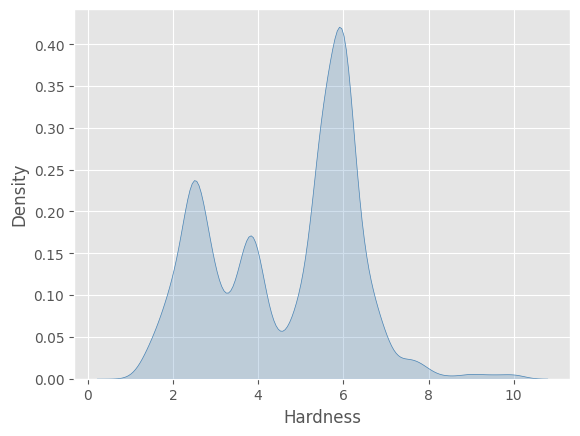

In [7]:
sns.kdeplot(data = train, x = 'Hardness', fill = True, color = 'steelblue');

The above plot shows `Hardness` is multi-modal. Next, we explore the relationship between the input features and `Hardness` by first creating a heatmap.

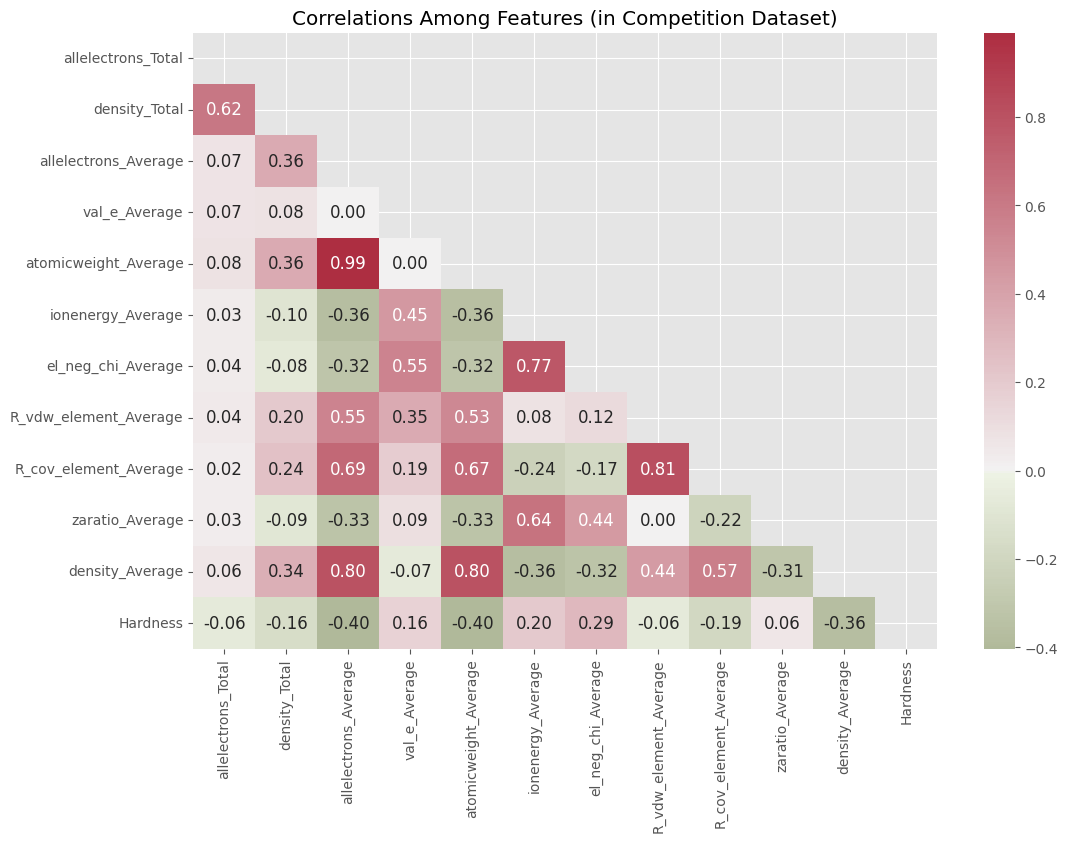

In [8]:
corr_mat_data = train.drop(columns = ['id'], axis = 1).corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (12, 8))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)');

From the above, these are a couple of observations:

- `atomicweight_Average` and `allelectrons_Average` are almost equal (99% correlation).
- `R_cov_element_Average` and `R_vdw_element_Average` are highly correlated (81% correlation).
- `density_Average` is highly correlated with `allelectrons_Average` and `atomicweight_Average` (80% correlation).
- `allelectrons_Average` is the features with the highest correlation (in absolute value) with `Hardness`.

Next, we take a close look at the scatter-plots of the highly correlated features.

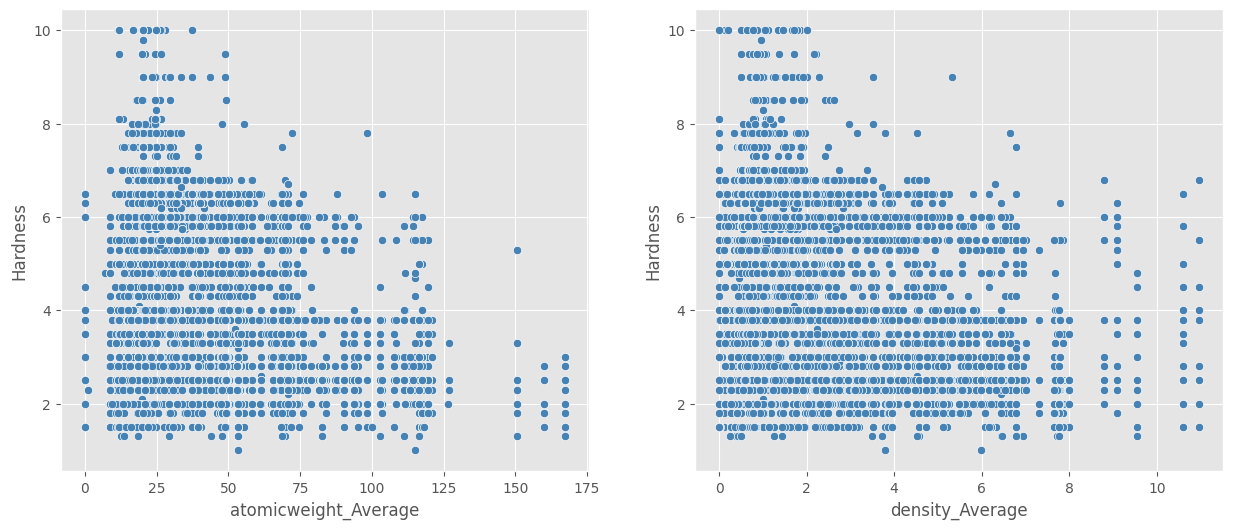

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = train, x = 'atomicweight_Average', y = 'Hardness', color = 'steelblue')
sns.scatterplot(ax = axes[1], data = train, x = 'density_Average', y = 'Hardness', color = 'steelblue');

In terms of patterns, not much to learnt from the above plots. However, 

- In the left panel, there are a few data points (on the bottom right) that seem to be outliers (in `atomicweight_Average`).
- In the right panel, there are a few data points (on the right) that seem to be outliers (in `density_Average`).

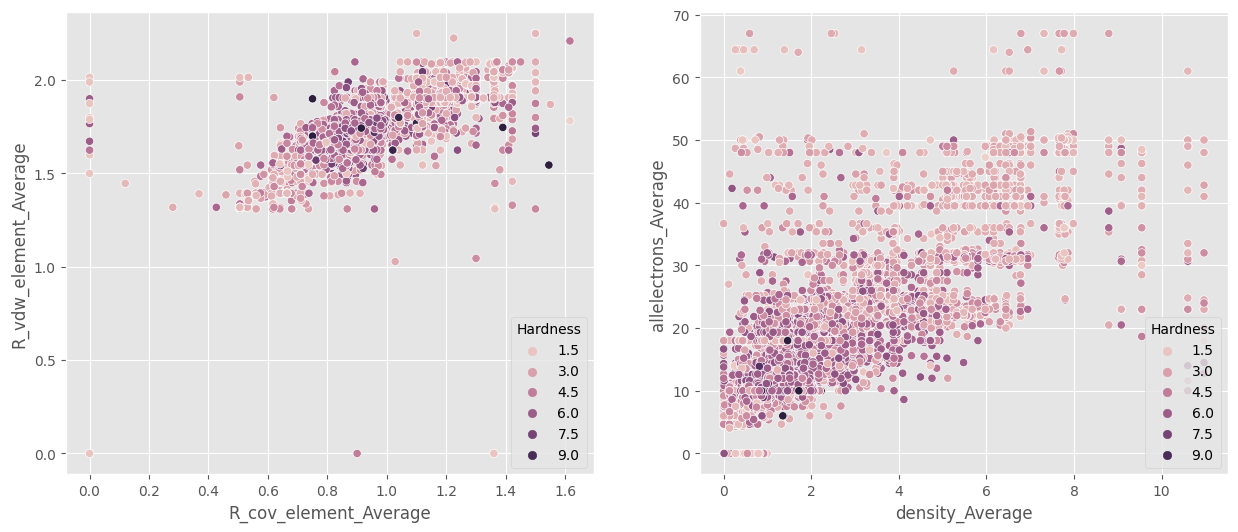

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = train, x = 'R_cov_element_Average', y = 'R_vdw_element_Average', hue = 'Hardness')
sns.scatterplot(ax = axes[1], data = train, x = 'density_Average', y = 'allelectrons_Average', hue = 'Hardness');

From the above plots, these are some observations:

- In the left panel, there are several outliers.
- In the right panel, it seems the top half of the plot (`allelectrosn_Average > 40`) `Hardness` is less than or equal to 4.5. 
- Also, in the right panel, there are several outliers.

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

We start by modeling (using standard models) with raw data with minimum transformation. First, we define the input, target variables and the cross-validation folds.

In [11]:
X = train.drop(columns = ['id', 'atomicweight_Average', 'Hardness'], axis = 1)
Y = train['Hardness']

skf = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

First, we train the `KNeighborsRegressor` model with different number of neighbors as follows.

In [12]:
stand_tran = make_pipeline(PowerTransformer())
# stand_tran = make_pipeline(RobustScaler())

proccessor = make_column_transformer(
    (stand_tran, ('allelectrons_Total', 'density_Total',
                  'allelectrons_Average', 'val_e_Average',
                  'ionenergy_Average', 'el_neg_chi_Average',
                  'R_vdw_element_Average', 'R_cov_element_Average',
                  'zaratio_Average', 'density_Average')), 
    remainder = 'passthrough')

knn = make_pipeline(proccessor, KNeighborsRegressor())
knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer())]),
                                                  ('allelectrons_Total',
                                                   'density_Total',
                                                   'allelectrons_Average',
                                                   'val_e_Average',
                                                   'ionenergy_Average',
                                                   'el_neg_chi_Average',
                                                   'R_vdw_element_Average',
                                                   'R_cov_element_Average',
                                                   'zaratio_Average',
                                                   'density_Average'))])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [13]:
for i in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 150, 200]:
    
    knn_cv_routine = cross_val_score(make_pipeline(proccessor, KNeighborsRegressor(n_neighbors = i)), X, Y,
                                     scoring = 'neg_median_absolute_error',
                                     cv = skf,
                                     n_jobs = -1)

    print(f"The average oof Median absolure error score of the k-NN model with {i} neighbors is {-1*knn_cv_routine.mean()}")

The average oof Median absolure error score of the k-NN model with 5 neighbors is 0.7239999999999998
The average oof Median absolure error score of the k-NN model with 10 neighbors is 0.7025000000000001
The average oof Median absolure error score of the k-NN model with 15 neighbors is 0.7070000000000002
The average oof Median absolure error score of the k-NN model with 20 neighbors is 0.7192499999999998
The average oof Median absolure error score of the k-NN model with 25 neighbors is 0.7250000000000001
The average oof Median absolure error score of the k-NN model with 30 neighbors is 0.7261666666666668
The average oof Median absolure error score of the k-NN model with 35 neighbors is 0.7302142857142856
The average oof Median absolure error score of the k-NN model with 40 neighbors is 0.7354375000000001
The average oof Median absolure error score of the k-NN model with 45 neighbors is 0.7376111111111112
The average oof Median absolure error score of the k-NN model with 50 neighbors is 

Ten neighbors seems the be appropriate number of neighbors for this dataset. Next, we proceed to train `RandomForestRegressor` on the `train` dataset.

Next, we proceed to train the `GradientBoostingRegressor` model on the `train` dataset.

In [14]:
GB_cv_routine = cross_val_score(GradientBoostingRegressor(loss = 'absolute_error',
                                                          n_estimators = 300,
                                                          learning_rate = 0.1,
                                                          min_samples_leaf = 30,
                                                          max_depth = 5), 
                                X,
                                Y,
                                scoring = 'neg_median_absolute_error',
                                cv = skf, 
                                n_jobs = -1)

print(f"The average oof Median absolure error score of the GB model is {-1*GB_cv_routine.mean()}")

The average oof Median absolure error score of the GB model is 0.5337928560757206


Next, we proceed to train the `HistGradientBoostingRegressor` model on the `train` dataset.

In [15]:
HistGB_cv_routine = cross_val_score(HistGradientBoostingRegressor(loss = 'absolute_error',
                                                                  max_iter = 300,
                                                                  learning_rate = 0.1,
                                                                  min_samples_leaf = 30,
                                                                  max_depth = 5, 
                                                                  random_state = 1), 
                                    X,
                                    Y,
                                    scoring = 'neg_median_absolute_error',
                                    cv = skf, 
                                    n_jobs = -1)

print(f"The average oof Median absolure error score of the HistGB model is {-1*HistGB_cv_routine.mean()}")

The average oof Median absolure error score of the HistGB model is 0.5401412730035817


Next, we proceed to train the `LGBRegressor` model on the `train` dataset.

In [16]:
LGBM_cv_routine = cross_val_score(LGBMRegressor(objective = 'mae',
                                                n_estimators = 300,
                                                learning_rate = 0.1,
                                                colsample_bytree = 0.6), 
                                  X,
                                  Y,
                                  scoring = 'neg_median_absolute_error',
                                  cv = skf, 
                                  n_jobs = -1)

print(f"The average oof Median absolure error score of the LGBM model is {-1*LGBM_cv_routine.mean()}")

The average oof Median absolure error score of the LGBM model is 0.5302365278001064


Next, we proceed to train the `XGBRegressor` model on the `train` dataset.

In [17]:
XGB_cv_routine = cross_val_score(XGBRegressor(objective = 'reg:absoluteerror',
                                              tree_method = 'hist',
                                              n_estimators = 300,
                                              learning_rate = 0.1,
                                              colsample_bytree = 0.6), 
                                 X,
                                 Y,
                                 scoring = 'neg_median_absolute_error',
                                 cv = skf, 
                                 n_jobs = -1)

print(f"The average oof Median absolure error score of the XGB model is {-1*XGB_cv_routine.mean()}")

The average oof Median absolure error score of the XGB model is 0.5350464749336241


In [18]:
Cat_cv_routine = cross_val_score(CatBoostRegressor(objective = 'MAE',
                                                   iterations = 300,
                                                   learning_rate = 0.1,
                                                   verbose = False), 
                                 X,
                                 Y,
                                 scoring = 'neg_median_absolute_error',
                                 cv = skf, 
                                 n_jobs = -1)

print(f"The average oof Median absolure error score of the CatBoost model is {-1*Cat_cv_routine.mean()}")

The average oof Median absolure error score of the CatBoost model is 0.5518818906488897


In [19]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['GB', 'Hist', 'LGBM', 'XGB', 'Cat']
model_performance['10-folds oof Median Absolute Error'] = [-1*GB_cv_routine.mean(), -1*HistGB_cv_routine.mean(), -1*LGBM_cv_routine.mean(), -1*XGB_cv_routine.mean(), -1*Cat_cv_routine.mean()]
print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")

The followig table shows the performance of the considered models: 

  Model  10-folds oof Median Absolute Error
0    GB                            0.533793
1  Hist                            0.540141
2  LGBM                            0.530237
3   XGB                            0.535046
4   Cat                            0.551882


Next, we build two model: `VotingRegressor` and `StackerRegressor` as follows:

In [20]:
md1 = make_pipeline(PowerTransformer(), GradientBoostingRegressor(**{'loss': 'absolute_error',
 'max_depth': 10,
 'learning_rate': 0.041599576923587865,
 'n_estimators': 139,
 'min_samples_leaf': 42,
 'min_samples_split': 11,
 'random_state': 1}))

md2 = make_pipeline(MinMaxScaler(), HistGradientBoostingRegressor(**{'loss': 'absolute_error',
 'l2_regularization': 0.027030940923710774,
 'early_stopping': False,
 'learning_rate': 0.019042088959167168,
 'max_iter': 949,
 'max_depth': 14,
 'max_bins': 255,
 'min_samples_leaf': 50,
 'max_leaf_nodes': 50}))

md3 = LGBMRegressor(**{'objective': 'mae',
 'n_estimators': 668,
 'learning_rate': 0.018499866546319983,
 'max_depth': 11,
 'reg_alpha': 0.4618095706853164,
 'reg_lambda': 0.07505699333277592,
 'num_leaves': 88,
 'subsample': 0.7994357898443023,
 'colsample_bytree': 0.7716446660869791})

md4 = make_pipeline(MinMaxScaler(), XGBRegressor(**{'objective': 'reg:absoluteerror',
 'tree_method': 'hist',
 'max_depth': 7,
 'learning_rate': 0.01912673399861771,
 'n_estimators': 960,
 'gamma': 1.3282085968831892,
 'min_child_weight': 28,
 'colsample_bytree': 0.6171930281823468,
 'subsample': 0.762767668956589}))

md5 = CatBoostRegressor(**{'objective': 'MAE',
 'iterations': 792,
 'learning_rate': 0.033323612065351636,
 'depth': 7,
 'random_strength': 0.04415624028064764,
 'bagging_temperature': 0.5522406534278442,
 'border_count': 241,
 'l2_leaf_reg': 8,
 'verbose': False,
 'task_type': 'CPU'})

md6 = make_pipeline(PowerTransformer(), SVR(kernel = 'rbf', 
                                            C = 10,
                                            gamma = 0.1, 
                                            epsilon = 0.01))

voting_regressor = VotingRegressor(estimators = [('GB', md1),
                                                 ('HGB', md2),
                                                 ('LGBM', md3),
                                                 ('XGB', md4),
                                                 ('Cat', md5)],
                                  n_jobs = -1, 
                                  weights = [0.002309, 0.254678, 0.363684, 0.300134, 0.074709])
voting_regressor

VotingRegressor(estimators=[('GB',
                             Pipeline(steps=[('powertransformer',
                                              PowerTransformer()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(learning_rate=0.041599576923587865,
                                                                        loss='absolute_error',
                                                                        max_depth=10,
                                                                        min_samples_leaf=42,
                                                                        min_samples_split=11,
                                                                        n_estimators=139,
                                                                        random_state=1))])),
                            ('HGB',
                             Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('...
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=7,
                                                           max_leaves=None,
                                                           min_child_weight=28,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=960,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           objective='reg:absoluteerror', ...))])),
                            ('Cat',
                             <catboost.core.CatBoostRegressor object at 0x79d81c5635b0>)],
                n_jobs=-1,
                weights=[0.002309, 0.254678, 0.363684, 0.300134, 0.074709])

In [21]:
stacker = StackingRegressor(estimators = [('GB', md1),
                                          ('HGB', md2),
                                          ('LGBM', md3),
                                          ('XGB', md4),
                                          ('Cat', md5)],
                            n_jobs = -1, 
                            final_estimator = LADRegression())
stacker

StackingRegressor(estimators=[('GB',
                               Pipeline(steps=[('powertransformer',
                                                PowerTransformer()),
                                               ('gradientboostingregressor',
                                                GradientBoostingRegressor(learning_rate=0.041599576923587865,
                                                                          loss='absolute_error',
                                                                          max_depth=10,
                                                                          min_samples_leaf=42,
                                                                          min_samples_split=11,
                                                                          n_estimators=139,
                                                                          random_state=1))])),
                              ('HGB',
                               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),...
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=7,
                                                             max_leaves=None,
                                                             min_child_weight=28,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=960,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             objective='reg:absoluteerror', ...))])),
                              ('Cat',
                               <catboost.core.CatBoostRegressor object at 0x79d81c5635b0>)],
                  final_estimator=LADRegression(), n_jobs=-1)

Next, we proceed to build the cross-validation routine.

In [22]:
vot_scores, vot_preds = list(), list()
stack_scores, stack_preds = list(), list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print('----------------------------------------------------------')
    
    ############
    ## Voting ##
    ############
    
    vot = voting_regressor.fit(X_train, Y_train)
    vot_pred = vot.predict(X_test)
    
    vot_score = median_absolute_error(Y_test, vot_pred)
    vot_scores.append(vot_score)
    
    print('Fold', i, '==> Voting Regressor oof median absolute error score is ==>', vot_score)
    
    vot_pred_test = vot.predict(test.drop(columns = ['id', 'atomicweight_Average'], axis = 1))
    vot_preds.append(vot_pred_test)
    
    #############
    ## Stacker ##
    #############
    
    stack = stacker.fit(X_train, Y_train)
    stack_pred = stack.predict(X_test)
    
    stack_score = median_absolute_error(Y_test, stack_pred)
    stack_scores.append(stack_score)
    
    print('Fold', i, '==> Stacking Regressor oof median absolute error score is ==>', stack_score)
    
    stack_pred_test = stack.predict(test.drop(columns = ['id', 'atomicweight_Average'], axis = 1))
    stack_preds.append(stack_pred_test)

----------------------------------------------------------
Fold 0 ==> Voting Regressor oof median absolute error score is ==> 0.49609987271717415
Fold 0 ==> Stacking Regressor oof median absolute error score is ==> 0.507646895955701
----------------------------------------------------------
Fold 1 ==> Voting Regressor oof median absolute error score is ==> 0.5120088203646027
Fold 1 ==> Stacking Regressor oof median absolute error score is ==> 0.5170554130431677
----------------------------------------------------------
Fold 2 ==> Voting Regressor oof median absolute error score is ==> 0.5017178350490852
Fold 2 ==> Stacking Regressor oof median absolute error score is ==> 0.49423183732711085
----------------------------------------------------------
Fold 3 ==> Voting Regressor oof median absolute error score is ==> 0.518964555854311
Fold 3 ==> Stacking Regressor oof median absolute error score is ==> 0.5217407028242738
----------------------------------------------------------
Fold 4 ==

In [23]:
print(f"The average oof median absolute error score of voting regressor model is {np.mean(vot_scores)}")
print(f"The average oof median absolute error score of stacking regressor model is {np.mean(stack_scores)}")

The average oof median absolute error score of voting regressor model is 0.5202478954780915
The average oof median absolute error score of stacking regressor model is 0.5201870339839272


In [24]:
voting_full = voting_regressor.fit(X, Y)

voting_pred_full = voting_full.predict(test.drop(columns = ['id', 'atomicweight_Average'], axis = 1))
voting_pred_cv = pd.DataFrame(vot_preds).apply(np.median, axis = 0)

voting = (voting_pred_full + voting_pred_cv) / 2
submission['Hardness'] = voting
submission.head()

,id,Hardness
0,10407,2.615389
1,10408,2.548962
2,10409,6.008095
3,10410,4.308342
4,10411,5.355002


In [25]:
submission.to_csv('Voting_baseline_sub.csv', index = False)

In [26]:
stacker_full = stacker.fit(X, Y)

stacker_pred_full = stacker_full.predict(test.drop(columns = ['id', 'atomicweight_Average'], axis = 1))
stacker_pred_cv = pd.DataFrame(stack_preds).apply(np.median, axis = 0)

stacking = (stacker_pred_full + stacker_pred_cv) / 2
submission['Hardness'] = stacking
submission.head()

,id,Hardness
0,10407,2.569433
1,10408,2.540628
2,10409,6.025345
3,10410,4.319341
4,10411,5.402557


In [27]:
submission.to_csv('Stacking_baseline_sub.csv', index = False)

In [28]:
submission_1 = submission.copy()
submission_1['Hardness'] = (stacking + voting) / 2
submission_1.head()

,id,Hardness
0,10407,2.592411
1,10408,2.544795
2,10409,6.016720
3,10410,4.313842
4,10411,5.378780


In [29]:
submission_1.to_csv('Voting_Stacking_baseline_sub.csv', index = False)

<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In this section, we build the models using `sample_weight` to optimize the `median_abosulte_error` as suggested by @ambrosm in this [post](https://www.kaggle.com/competitions/playground-series-s3e25/discussion/455888). First, we define the input and target features.

In [30]:
X = train.drop(columns = ['id', 'atomicweight_Average', 'Hardness'], axis = 1)
Y = train['Hardness']

test = pd.read_csv('../input/playground-series-s3e25/test.csv')
test = test.drop(columns = ['id', 'atomicweight_Average'], axis = 1)

skf = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

Then we define the function to tune the `sample_weight`.

In [31]:
def model_sample_weights(md, X_train, Y_train, X_test, Y_test, test, flag):

    base_weight = 0.01
    lower, upper = 0.06, 0.7

    md_fit = md.fit(X_train, Y_train)
    md_pred = md_fit.predict(X_test)
    md_score = median_absolute_error(Y_test, md_pred)
    
    train_score = np.abs(Y_train - md_fit.predict(X_train))
    sample_weight_tr = base_weight + ((lower < train_score) & (train_score < upper))

    if flag:
        
        md_fit = md.fit(X_train, Y_train, model__sample_weight = sample_weight_tr)
        md_pred = md_fit.predict(X_test)

        return [cross_val_predict(md, X_train, Y_train, fit_params = {'model__sample_weight': sample_weight_tr},
                                  cv = kf, n_jobs = -1),
                md_pred,
                md_fit.predict(test)]
        
    else: 
        
        md_fit = md.fit(X_train, Y_train, sample_weight = sample_weight_tr)
        md_pred = md_fit.predict(X_test)
    
        return [cross_val_predict(md, X_train, Y_train, fit_params = {'sample_weight': sample_weight_tr}, 
                                  cv = kf, n_jobs = -1),
                md_pred,
                md_fit.predict(test)]

In [32]:
def hill_climbing(x, y, x_test, test):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = median_absolute_error(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = False)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]
    test = test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    current_best_test_test_preds = test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    # weight_range = np.arange(-0.5, 0.51, 0.01)
    weight_range = np.arange(0.01, 0.51, 0.01)
    history = [median_absolute_error(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = median_absolute_error(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = median_absolute_error(y, potential_ensemble)
                if cv_score < potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            current_best_test_test_preds = (1 - wgt_best) * current_best_test_test_preds + wgt_best * test[k_best]
            MODELS = MODELS.drop(k_best, axis = 1)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds
    hill_ens_pred_3 = current_best_test_test_preds
    
    return [hill_ens_pred_1, hill_ens_pred_2, hill_ens_pred_3]


md1 = Pipeline([('stand', MinMaxScaler()), 
                ('model', HistGradientBoostingRegressor(**{'loss': 'absolute_error',
                                                            'l2_regularization': 0.027030940923710774,
                                                            'early_stopping': False,
                                                            'learning_rate': 0.019042088959167168,
                                                            'max_iter': 949,
                                                            'max_depth': 14,
                                                            'max_bins': 255,
                                                            'min_samples_leaf': 50,
                                                            'max_leaf_nodes': 50}))])

md2 = Pipeline([('stand', MinMaxScaler()), 
                ('model', HistGradientBoostingRegressor(**{'loss': 'absolute_error',
                                                           'l2_regularization': 0.41075533093698835,
                                                           'early_stopping': False,
                                                           'learning_rate': 0.04559754489178127,
                                                           'max_iter': 934,
                                                           'max_depth': 14,
                                                           'max_bins': 125,
                                                           'min_samples_leaf': 48,
                                                           'max_leaf_nodes': 44,
                                                           'random_state': 10}))])

md3 = LGBMRegressor(**{'objective': 'mae',
 'n_estimators': 668,
 'learning_rate': 0.018499866546319983,
 'max_depth': 11,
 'reg_alpha': 0.4618095706853164,
 'reg_lambda': 0.07505699333277592,
 'num_leaves': 88,
 'subsample': 0.7994357898443023,
 'colsample_bytree': 0.7716446660869791})

md4 = LGBMRegressor(**{'objective': 'mae',
 'n_estimators': 418,
 'learning_rate': 0.04970452376173503,
 'max_depth': 9,
 'reg_alpha': 0.4671001725618798,
 'reg_lambda': 0.046001674047501155,
 'num_leaves': 42,
 'subsample': 0.33242918746024247,
 'colsample_bytree': 0.8708402901170365})

md5 = LGBMRegressor(**{'objective': 'quantile',
 'alpha': 0.5,
 'n_estimators': 684,
 'learning_rate': 0.016085895386454465,
 'max_depth': 12,
 'reg_alpha': 0.6572192610779798,
 'reg_lambda': 0.02564469481300245,
 'num_leaves': 55,
 'subsample': 0.34379306525592995,
 'colsample_bytree': 0.8093898572381174})

md6 = CatBoostRegressor(**{'objective': 'MAE',
 'iterations': 792,
 'learning_rate': 0.033323612065351636,
 'depth': 7,
 'random_strength': 0.04415624028064764,
 'bagging_temperature': 0.5522406534278442,
 'border_count': 241,
 'l2_leaf_reg': 8,
 'verbose': False,
 'task_type': 'CPU'})

md7 = CatBoostRegressor(**{'objective': 'MAE',
 'iterations': 936,
 'learning_rate': 0.03243557362128725,
 'depth': 11,
 'random_strength': 0.0792068075436855,
 'bagging_temperature': 0.08117249085611788,
 'border_count': 212,
 'l2_leaf_reg': 27,
 'verbose': False,
 'task_type': 'CPU',
 'grow_policy': 'Lossguide'})

md8 = CatBoostRegressor(**{'objective': 'MAE',
 'iterations': 942,
 'learning_rate': 0.02359171465972593,
 'depth': 10,
 'random_strength': 0.02563230761217033,
 'bagging_temperature': 0.28083483762738604,
 'border_count': 115,
 'l2_leaf_reg': 20,
 'verbose': False,
 'task_type': 'CPU',
 'grow_policy': 'Lossguide'})

Next, we run the cross-validation routine.

In [33]:
median_scores, median_preds, median_preds_test = list(), list(), list()
LDA_scores, LDA_preds, LDA_preds_test = list(), list(), list()
hill_scores, hill_preds, hill_preds_test = list(), list(), list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('--------------------------------------------------------------')

    md_train_preds = pd.DataFrame()
    md_test_preds = pd.DataFrame()
    md_test_test_preds = pd.DataFrame()

    ###########
    ## HGB 1 ##
    ###########
    
    HGB_md_1 = model_sample_weights(md1, X_train, Y_train, X_test, Y_test, test, True)

    md_train_preds['HGB_1'] = HGB_md_1[0]
    md_test_preds['HGB_1'] = HGB_md_1[1]
    md_test_test_preds['HGB_1'] = HGB_md_1[2]

    HGB_score_1 = median_absolute_error(Y_test, HGB_md_1[1])
    print('Fold', i, '==> HGB 1 (sample weights) oof median absolute error score is ==>', HGB_score_1)
    
    ###########
    ## HGB 2 ##
    ###########

    HGB_md_2 = model_sample_weights(md2, X_train, Y_train, X_test, Y_test, test, True)

    md_train_preds['HGB_2'] = HGB_md_2[0]
    md_test_preds['HGB_2'] = HGB_md_2[1]
    md_test_test_preds['HGB_2'] = HGB_md_2[2]

    HGB_score_2 = median_absolute_error(Y_test, HGB_md_2[1])
    print('Fold', i, '==> HGB 2 (sample weights) oof median absolute error score is ==>', HGB_score_2)
    
    ############
    ## LGBM 1 ##
    ############

    LGBM_md_1 = model_sample_weights(md3, X_train, Y_train, X_test, Y_test, test, False)

    md_train_preds['LGBM_1'] = LGBM_md_1[0]
    md_test_preds['LGBM_1'] = LGBM_md_1[1]
    md_test_test_preds['LGBM_1'] = LGBM_md_1[2]

    LGBM_score_1 = median_absolute_error(Y_test, LGBM_md_1[1])
    print('Fold', i, '==> LGBM 1 (sample weights) oof median absolute error score is ==>', LGBM_score_1)
    
    ############
    ## LGBM 2 ##
    ############

    LGBM_md_2 = model_sample_weights(md4, X_train, Y_train, X_test, Y_test, test, False)

    md_train_preds['LGBM_2'] = LGBM_md_2[0]
    md_test_preds['LGBM_2'] = LGBM_md_2[1]
    md_test_test_preds['LGBM_2'] = LGBM_md_2[2]

    LGBM_score_2 = median_absolute_error(Y_test, LGBM_md_2[1])
    print('Fold', i, '==> LGBM 2 (sample weights) oof median absolute error score is ==>', LGBM_score_2)
    
    ############
    ## LGBM 3 ##
    ############

    LGBM_md_3 = model_sample_weights(md5, X_train, Y_train, X_test, Y_test, test, False)

    md_train_preds['LGBM_3'] = LGBM_md_3[0]
    md_test_preds['LGBM_3'] = LGBM_md_3[1]
    md_test_test_preds['LGBM_3'] = LGBM_md_3[2]

    LGBM_score_3 = median_absolute_error(Y_test, LGBM_md_3[1])
    print('Fold', i, '==> LGBM 3 (sample weights) oof median absolute error score is ==>', LGBM_score_3)
    
    ################
    ## CatBoost 1 ##
    ################

    Cat_md_1 = model_sample_weights(md6, X_train, Y_train, X_test, Y_test, test, False)

    md_train_preds['Cat_1'] = Cat_md_1[0]
    md_test_preds['Cat_1'] = Cat_md_1[1]
    md_test_test_preds['Cat_1'] = Cat_md_1[2]

    Cat_score_1 = median_absolute_error(Y_test, Cat_md_1[1])
    print('Fold', i, '==> CatBoost 1 (sample weights) oof median absolute error score is ==>', Cat_score_1)
    
    ################
    ## CatBoost 2 ##
    ################

    Cat_md_2 = model_sample_weights(md7, X_train, Y_train, X_test, Y_test, test, False)

    md_train_preds['Cat_2'] = Cat_md_2[0]
    md_test_preds['Cat_2'] = Cat_md_2[1]
    md_test_test_preds['Cat_2'] = Cat_md_2[2]

    Cat_score_2 = median_absolute_error(Y_test, Cat_md_2[1])
    print('Fold', i, '==> CatBoost 2 (sample weights) oof median absolute error score is ==>', Cat_score_2)
    
    ################
    ## CatBoost 3 ##
    ################

    Cat_md_3 = model_sample_weights(md8, X_train, Y_train, X_test, Y_test, test, False)

    md_train_preds['Cat_3'] = Cat_md_3[0]
    md_test_preds['Cat_3'] = Cat_md_3[1]
    md_test_test_preds['Cat_3'] = Cat_md_3[2]

    Cat_score_3 = median_absolute_error(Y_test, Cat_md_3[1])
    print('Fold', i, '==> CatBoost 3 (sample weights) oof median absolute error score is ==>', Cat_score_3)
    
    ####################
    ## Median Stacker ##
    ####################

    median_pred = md_test_preds.apply(np.median, axis = 1)
    median_score = median_absolute_error(Y_test, median_pred)
    median_scores.append(median_score)
    median_preds.append(median_pred)

    median_pred_test = md_test_test_preds.apply(np.median, axis = 1)
    median_preds_test.append(median_pred_test)

    print('Fold', i, '==> Median Stacker oof median absolute error score is ==>', median_score)
    
    #################
    ## LDA Stacker ##
    #################

    LDA_md = LADRegression().fit(md_train_preds.iloc[:, 0:5], Y_train)
    LDA_pred = LDA_md.predict(md_test_preds.iloc[:, 0:5])
    LDA_pred_test = LDA_md.predict(md_test_test_preds.iloc[:, 0:5])
    LDA_score = median_absolute_error(Y_test, LDA_pred)
    LDA_scores.append(LDA_score)
    LDA_preds.append(LDA_pred)
    LDA_preds_test.append(LDA_pred_test)
    
    print('Fold', i, '==> LDA Stacker oof median absolute error score is ==>', LDA_score)
    
    ###################
    ## Hill Climbing ##
    ###################

    hill_results = hill_climbing(md_train_preds, Y_train, md_test_preds, md_test_test_preds)
    hill_train = hill_results[0]
    train_score = median_absolute_error(Y_train, hill_train)
    
    hill_test = hill_results[1]
    test_score = median_absolute_error(Y_test, hill_test)
    hill_scores.append(test_score)
    hill_preds.append(hill_test)
    
    hill_preds_test.append(hill_results[2])
    
    # # print('Fold', i, '==> Hill Climbing in-sample median absolute error score is ==>', train_score)
    print('Fold', i, '==> Hill Climbing oof median absolute error score is ==>', test_score)

--------------------------------------------------------------
Fold 0 ==> HGB 1 (sample weights) oof median absolute error score is ==> 0.4754485851972814
Fold 0 ==> HGB 2 (sample weights) oof median absolute error score is ==> 0.4551603294366666
Fold 0 ==> LGBM 1 (sample weights) oof median absolute error score is ==> 0.49637265299284294
Fold 0 ==> LGBM 2 (sample weights) oof median absolute error score is ==> 0.47573120257593304
Fold 0 ==> LGBM 3 (sample weights) oof median absolute error score is ==> 0.4841681654606802
Fold 0 ==> CatBoost 1 (sample weights) oof median absolute error score is ==> 0.5519512380625025
Fold 0 ==> CatBoost 2 (sample weights) oof median absolute error score is ==> 0.5047116635578321
Fold 0 ==> CatBoost 3 (sample weights) oof median absolute error score is ==> 0.4812663478547319
Fold 0 ==> Median Stacker oof median absolute error score is ==> 0.47465013261147426
Fold 0 ==> LDA Stacker oof median absolute error score is ==> 0.47719318449965886
Fold 0 ==> Hil

In [34]:
print(f"The oof median absolute error score of the Median Stacker is {np.mean(median_scores)}")
print(f"The oof median absolute error score of the LDA Stacker is {np.mean(LDA_scores)}")
print(f"The oof median absolute error score of the Hill Climbing is {np.mean(hill_scores)}")

The oof median absolute error score of the Median Stacker is 0.48234730265748793
The oof median absolute error score of the LDA Stacker is 0.49269548400733976
The oof median absolute error score of the Hill Climbing is 0.4839662362379655


In [35]:
med_pred_cv = pd.DataFrame(median_preds_test).apply(np.median, axis = 0)
LDA_pred_cv = pd.DataFrame(LDA_preds_test).apply(np.median, axis = 0)
hill_pred_cv = pd.DataFrame(hill_preds_test).apply(np.median, axis = 0)

model_preds = pd.DataFrame()
model_preds['LDA'] = LDA_pred_cv
model_preds['MED'] = med_pred_cv
model_preds['HILL'] = hill_pred_cv

submission_2 = submission.copy()
submission_2['Hardness'] = model_preds.apply(np.median, axis = 1)
submission_2.head()

,id,Hardness
0,10407,2.386626
1,10408,2.520987
2,10409,5.790057
3,10410,4.440443
4,10411,4.925160


In [36]:
submission_2.to_csv('Median_LDA_Hill_sample_weight_sub.csv', index = False)

<a id="7"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 3.0</h1>

In the previuous two baseline modeling, `atomicweight_Average` was removed because it is highly correlated with `allelectrons_Average`. In this version, we keep it in the models. First, we define the `input` and `target`.

In [37]:
X = train.drop(columns = ['id', 'Hardness'], axis = 1)
Y = train['Hardness']

test = pd.read_csv('../input/playground-series-s3e25/test.csv')
test = test.drop(columns = ['id'], axis = 1)

skf = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

In [38]:
md1 = HistGradientBoostingRegressor(**{'loss': 'absolute_error', 
                                       'l2_regularization': 1.3964176081789386, 
                                       'early_stopping': False, 
                                       'learning_rate': 0.016009625548136137, 
                                       'max_iter': 1533, 
                                       'max_depth': 10, 
                                       'max_bins': 118, 
                                       'min_samples_leaf': 46, 
                                       'max_leaf_nodes': 41, 
                                       'random_state': 10})


md2 = Pipeline([('stand', MinMaxScaler()), 
                ('model', HistGradientBoostingRegressor(**{'loss': 'absolute_error', 
                                                           'l2_regularization': 0.0773440762323129, 
                                                           'early_stopping': False, 
                                                           'learning_rate': 0.07665261989200847, 
                                                           'max_iter': 244, 'max_depth': 8, 
                                                           'max_bins': 67, 
                                                           'min_samples_leaf': 26, 
                                                           'max_leaf_nodes': 45, 
                                                           'random_state': 10}))])

md3 = Pipeline([('stand', StandardScaler()), 
                ('model', HistGradientBoostingRegressor(**{'loss': 'absolute_error', 
                                                           'l2_regularization': 0.03234463289342263, 
                                                           'early_stopping': False, 
                                                           'learning_rate': 0.013152992006060682, 
                                                           'max_iter': 1791, 
                                                           'max_depth': 7, 
                                                           'max_bins': 97, 
                                                           'min_samples_leaf': 16, 
                                                           'max_leaf_nodes': 33, 
                                                           'random_state': 10}))])

md4 = Pipeline([('stand', RobustScaler()), 
                ('model', HistGradientBoostingRegressor(**{'loss': 'absolute_error', 
                                                           'l2_regularization': 0.16660827795253544, 
                                                           'early_stopping': False, 
                                                           'learning_rate': 0.0484806700732674, 
                                                           'max_iter': 657, 
                                                           'max_depth': 13, 
                                                           'max_bins': 172, 
                                                           'min_samples_leaf': 44, 
                                                           'max_leaf_nodes': 48, 
                                                           'random_state': 10}))])

md5 = LGBMRegressor(**{'objective': 'mae', 
                       'n_estimators': 1816, 
                       'learning_rate': 0.011960149701703357, 
                       'max_depth': 11, 
                       'reg_alpha': 2.943938939425285, 
                       'reg_lambda': 0.06527831358565354, 
                       'num_leaves': 98, 
                       'subsample': 0.7831190787928901, 
                       'colsample_bytree': 0.7169192797229946})


md6 = Pipeline([('stand', MinMaxScaler()), 
                ('model', LGBMRegressor(**{'objective': 'mae', 
                                           'n_estimators': 1461, 
                                           'learning_rate': 0.013343645844387813, 
                                           'max_depth': 8, 
                                           'reg_alpha': 0.5296906765102644, 
                                           'reg_lambda': 0.4622644322255429, 
                                           'num_leaves': 55, 
                                           'subsample': 0.44912198107158186, 
                                           'colsample_bytree': 0.6084534642705367}))])

md7 = Pipeline([('stand', StandardScaler()), 
                ('model', LGBMRegressor(**{'objective': 'mae', 
                                           'n_estimators': 548, 
                                           'learning_rate': 0.024315021778078507, 
                                           'max_depth': 11, 
                                           'reg_alpha': 1.9374435679081374, 
                                           'reg_lambda': 2.942038621536813, 
                                           'num_leaves': 61, 
                                           'subsample': 0.49955373075773585, 
                                           'colsample_bytree': 0.5690886596910012}))])


md8 = Pipeline([('stand', RobustScaler()), 
                ('model', LGBMRegressor(**{'objective': 'mae', 
                                           'n_estimators': 267, 
                                           'learning_rate': 0.05355930668936292, 
                                           'max_depth': 9, 
                                           'reg_alpha': 0.14455154126384284, 
                                           'reg_lambda': 0.04075237417599898, 
                                           'num_leaves': 62, 
                                           'subsample': 0.7416222141008473, 
                                           'colsample_bytree': 0.8919698784847256}))])


Next, we run the usual cross-validation routine.

In [39]:
md1_preds, md2_preds, md3_preds, md4_preds = list(), list(), list(), list()
md5_preds, md6_preds, md7_preds, md8_preds = list(), list(), list(), list()

vot_scores, vot_preds, vot_preds_test = list(), list(), list()
median_scores, median_preds, median_preds_test = list(), list(), list()
LDA_scores, LDA_preds, LDA_preds_test = list(), list(), list()
hill_scores, hill_preds, hill_preds_test = list(), list(), list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('--------------------------------------------------------------')

    md_train_preds = pd.DataFrame()
    md_test_preds = pd.DataFrame()
    md_test_test_preds = pd.DataFrame()

    ###########
    ## HGB 1 ##
    ###########
    
    HGB_md_1 = model_sample_weights(md1, X_train, Y_train, X_test, Y_test, test, False)

    md_train_preds['HGB_1'] = HGB_md_1[0]
    md_test_preds['HGB_1'] = HGB_md_1[1]
    md_test_test_preds['HGB_1'] = HGB_md_1[2]

    HGB_score_1 = median_absolute_error(Y_test, HGB_md_1[1])
    print('Fold', i, '==> HGB 1 (sample weights) oof median absolute error score is ==>', HGB_score_1)
    # md1_preds.append(HGB_md_1[1])
    
    ###########
    ## HGB 2 ##
    ###########

    HGB_md_2 = model_sample_weights(md2, X_train, Y_train, X_test, Y_test, test, True)

    md_train_preds['HGB_2'] = HGB_md_2[0]
    md_test_preds['HGB_2'] = HGB_md_2[1]
    md_test_test_preds['HGB_2'] = HGB_md_2[2]

    HGB_score_2 = median_absolute_error(Y_test, HGB_md_2[1])
    print('Fold', i, '==> HGB 2 (sample weights) oof median absolute error score is ==>', HGB_score_2)
    # md2_preds.append(HGB_md_2[1])

    ###########
    ## HGB 3 ##
    ###########

    HGB_md_3 = model_sample_weights(md3, X_train, Y_train, X_test, Y_test, test, True)

    md_train_preds['HGB_3'] = HGB_md_3[0]
    md_test_preds['HGB_3'] = HGB_md_3[1]
    md_test_test_preds['HGB_3'] = HGB_md_3[2]

    HGB_score_3 = median_absolute_error(Y_test, HGB_md_3[1])
    print('Fold', i, '==> HGB 3 (sample weights) oof median absolute error score is ==>', HGB_score_3)
    # md2_preds.append(HGB_md_3[1])

    ###########
    ## HGB 4 ##
    ###########

    HGB_md_4 = model_sample_weights(md4, X_train, Y_train, X_test, Y_test, test, True)

    md_train_preds['HGB_4'] = HGB_md_4[0]
    md_test_preds['HGB_4'] = HGB_md_4[1]
    md_test_test_preds['HGB_4'] = HGB_md_4[2]

    HGB_score_4 = median_absolute_error(Y_test, HGB_md_4[1])
    print('Fold', i, '==> HGB 4 (sample weights) oof median absolute error score is ==>', HGB_score_4)
    # md2_preds.append(HGB_md_3[1])

    ############
    ## LGBM 1 ##
    ############

    LGBM_md_1 = model_sample_weights(md5, X_train, Y_train, X_test, Y_test, test, False)

    md_train_preds['LGBM_1'] = LGBM_md_1[0]
    md_test_preds['LGBM_1'] = LGBM_md_1[1]
    md_test_test_preds['LGBM_1'] = LGBM_md_1[2]

    LGBM_score_1 = median_absolute_error(Y_test, LGBM_md_1[1])
    print('Fold', i, '==> LGBM 1 (sample weights) oof median absolute error score is ==>', LGBM_score_1)
    md3_preds.append(LGBM_md_1[1])
    
    ############
    ## LGBM 2 ##
    ############

    LGBM_md_2 = model_sample_weights(md6, X_train, Y_train, X_test, Y_test, test, True)

    md_train_preds['LGBM_2'] = LGBM_md_2[0]
    md_test_preds['LGBM_2'] = LGBM_md_2[1]
    md_test_test_preds['LGBM_2'] = LGBM_md_2[2]

    LGBM_score_2 = median_absolute_error(Y_test, LGBM_md_2[1])
    print('Fold', i, '==> LGBM 2 (sample weights) oof median absolute error score is ==>', LGBM_score_2)
    md4_preds.append(LGBM_md_2[1])
    
    ############
    ## LGBM 3 ##
    ############

    LGBM_md_3 = model_sample_weights(md7, X_train, Y_train, X_test, Y_test, test, True)

    md_train_preds['LGBM_3'] = LGBM_md_3[0]
    md_test_preds['LGBM_3'] = LGBM_md_3[1]
    md_test_test_preds['LGBM_3'] = LGBM_md_3[2]

    LGBM_score_3 = median_absolute_error(Y_test, LGBM_md_3[1])
    print('Fold', i, '==> LGBM 3 (sample weights) oof median absolute error score is ==>', LGBM_score_3)
    # md5_preds.append(LGBM_md_3[1])

    ############
    ## LGBM 4 ##
    ############

    LGBM_md_4 = model_sample_weights(md8, X_train, Y_train, X_test, Y_test, test, True)

    md_train_preds['LGBM_4'] = LGBM_md_4[0]
    md_test_preds['LGBM_4'] = LGBM_md_4[1]
    md_test_test_preds['LGBM_4'] = LGBM_md_4[2]

    LGBM_score_4 = median_absolute_error(Y_test, LGBM_md_4[1])
    print('Fold', i, '==> LGBM 4 (sample weights) oof median absolute error score is ==>', LGBM_score_4)
    # md5_preds.append(LGBM_md_3[1])
    
    #######################
    ## Median Prediction ##
    #######################

    median_pred = md_test_preds.apply(np.median, axis = 1)
    median_score = median_absolute_error(Y_test, median_pred)
    median_scores.append(median_score)
    median_preds.append(median_pred)

    median_pred_test = md_test_test_preds.apply(np.median, axis = 1)
    median_preds_test.append(median_pred_test)

    print('Fold', i, '==> Median Stacker oof median absolute error score is ==>', median_score)
    
    ########################
    ## Stacking Regressor ##
    ########################

    LDA_md = LADRegression().fit(md_train_preds, Y_train)
    LDA_pred = LDA_md.predict(md_test_preds)
    LDA_pred_test = LDA_md.predict(md_test_test_preds)
    LDA_score = median_absolute_error(Y_test, LDA_pred)
    LDA_scores.append(LDA_score)
    LDA_preds.append(LDA_pred)
    LDA_preds_test.append(LDA_pred_test)
    
    print('Fold', i, '==> LDA Stacker oof median absolute error score is ==>', LDA_score)
    
    ###################
    ## Hill Climbing ##
    ###################

    hill_results = hill_climbing(md_train_preds, Y_train, md_test_preds, md_test_test_preds)
    hill_train = hill_results[0]
    train_score = median_absolute_error(Y_train, hill_train)
    
    hill_test = hill_results[1]
    test_score = median_absolute_error(Y_test, hill_test)
    hill_scores.append(test_score)
    hill_preds.append(hill_test)
    
    hill_preds_test.append(hill_results[2])
    
    # # print('Fold', i, '==> Hill Climbing in-sample median absolute error score is ==>', train_score)
    print('Fold', i, '==> Hill Climbing oof median absolute error score is ==>', test_score)

--------------------------------------------------------------
Fold 0 ==> HGB 1 (sample weights) oof median absolute error score is ==> 0.48379327874421296
Fold 0 ==> HGB 2 (sample weights) oof median absolute error score is ==> 0.5016982316256149
Fold 0 ==> HGB 3 (sample weights) oof median absolute error score is ==> 0.47190091829722824
Fold 0 ==> HGB 4 (sample weights) oof median absolute error score is ==> 0.5052002773154873
Fold 0 ==> LGBM 1 (sample weights) oof median absolute error score is ==> 0.5022465067271114
Fold 0 ==> LGBM 2 (sample weights) oof median absolute error score is ==> 0.48217229699334574
Fold 0 ==> LGBM 3 (sample weights) oof median absolute error score is ==> 0.4827805814398749
Fold 0 ==> LGBM 4 (sample weights) oof median absolute error score is ==> 0.4806815508243174
Fold 0 ==> Median Stacker oof median absolute error score is ==> 0.47645228609469825
Fold 0 ==> LDA Stacker oof median absolute error score is ==> 0.4941972895048128
Fold 0 ==> Hill Climbing oof

In [40]:
print(f"The oof median absolute error score of the Median Stacker is {np.mean(median_scores)}")
print(f"The oof median absolute error score of the LDA Stacker is {np.mean(LDA_scores)}")
print(f"The oof median absolute error score of the Hill Climbing is {np.mean(hill_scores)}")

The oof median absolute error score of the Median Stacker is 0.47658852836292037
The oof median absolute error score of the LDA Stacker is 0.4860160641909463
The oof median absolute error score of the Hill Climbing is 0.4833456014493492


In [41]:
med_pred_cv = pd.DataFrame(median_preds_test).apply(np.median, axis = 0)
LDA_pred_cv = pd.DataFrame(LDA_preds_test).apply(np.median, axis = 0)
hill_pred_cv = pd.DataFrame(hill_preds_test).apply(np.median, axis = 0)

model_preds = pd.DataFrame()
model_preds['LDA'] = LDA_pred_cv
model_preds['MED'] = med_pred_cv
model_preds['HILL'] = hill_pred_cv

submission_3 = submission.copy()
submission_3['Hardness'] = model_preds.apply(np.median, axis = 1)
submission_3.head()

,id,Hardness
0,10407,2.402132
1,10408,2.479047
2,10409,5.818545
3,10410,4.756925
4,10411,4.954281


In [42]:
submission_3.to_csv('Median_LDA_Hill_sample_weight_sub_1.csv', index = False)

<a id="8"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 4.0</h1>

In this section, we implement the network architecture that was presented in this [notebook](https://www.kaggle.com/code/enricomanosperti/regression-with-a-mohs-hardness-dataset) from @enricomanosperti and in this [notebook](https://www.kaggle.com/code/paddykb/pg-s3e25-evaluate-the-lgbm-prefit-technique) from @paddykb.

In [43]:
X = train.drop(columns = ['id', 'Hardness'], axis = 1)
Y = train['Hardness']

test = pd.read_csv('../input/playground-series-s3e25/test.csv')
test = test.drop(columns = ['id'], axis = 1)

skf = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

First, we define the loss function.

In [44]:
def loss_fn(y_true, y_pred):
    
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q = 50)

Next, we define the model.

In [45]:
def create_model():

    input_layer = tf.keras.Input(shape = (12, ))
    x = tf.keras.layers.BatchNormalization(epsilon = 0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation = 'relu')(x)
    x = tf.keras.layers.Dense(32, activation = 'relu')(x)
    output_layer = tf.keras.layers.Dense(1)(x)    

    model = tf.keras.Model(inputs = input_layer, outputs = output_layer)

    model.compile(optimizer = tf.keras.optimizers.Adam(0.013, beta_1 = 0.5),
                  loss = loss_fn)

    return model

callbacks_list = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss', patience = 30, verbose = 0, mode = 'min', restore_best_weights = True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss', factor = 0.8, patience = 3, min_lr = 0.00001),
        tf.keras.callbacks.TerminateOnNaN()
    ] 


Next, we run the usual cross-validation routine.

In [46]:
tf_scores, tf_preds = list(), list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('--------------------------------------------------------------')
    
    x_train = X_train.copy()
    x_test = X_test.copy()
    test_cv = test.copy()
    
    ##########
    ## LGBM ##
    ##########
    
    LGBM_md = LGBMRegressor().fit(X_train, Y_train)

    x_train.loc[:, 'LGBM_1'] = LGBM_md.predict(X_train)
    x_test.loc[:, 'LGBM_1'] = LGBM_md.predict(X_test)
    test_cv.loc[:, 'LGBM_1'] = LGBM_md.predict(test)
    
    ########
    ## NN ##
    ########
    
    nn_md = create_model()
    nn_md.fit(x_train, Y_train,
              epochs = 100, 
              verbose = 0, 
              callbacks = callbacks_list)
    
    tf_md_pred = nn_md.predict(x_test, verbose = 0)
    tf_md_pred_test = nn_md.predict(test_cv, verbose = 0)
    tf_preds.append(tf_md_pred_test)
    
    tf_score = median_absolute_error(Y_test, tf_md_pred)
    
    tf_scores.append(tf_score)
    print('Fold', i, '==> TF oof median absolute error score is ==>', tf_score)

print(f"The TF oof median absolute error is {np.mean(tf_scores)}")

--------------------------------------------------------------
Fold 0 ==> TF oof median absolute error score is ==> 0.4258859157562256
--------------------------------------------------------------
Fold 1 ==> TF oof median absolute error score is ==> 0.5161252021789551
--------------------------------------------------------------
Fold 2 ==> TF oof median absolute error score is ==> 0.4147052764892578
--------------------------------------------------------------
Fold 3 ==> TF oof median absolute error score is ==> 0.4761476516723633
--------------------------------------------------------------
Fold 4 ==> TF oof median absolute error score is ==> 0.5272005081176756
--------------------------------------------------------------
Fold 5 ==> TF oof median absolute error score is ==> 0.4814858913421629
--------------------------------------------------------------
Fold 6 ==> TF oof median absolute error score is ==> 0.5538642406463623
-------------------------------------------------------

Next, we aggregate the predictions using the median.

In [47]:
tf_oof_preds = pd.DataFrame(np.concatenate(tf_preds, axis = 1))

submission_4 = submission.copy()
submission_4['Hardness'] = tf_oof_preds.apply(np.median, axis = 1)
submission_4.head()

,id,Hardness
0,10407,2.393281
1,10408,2.390134
2,10409,5.787288
3,10410,2.518053
4,10411,5.787288


In [48]:
submission_4.to_csv('TF_sub.csv', index = False)

<a id="9"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Ensemble Modeling</h1>

In this section, we ensemble the predictions from the previous four baseline modelings.

In [49]:
submission_1.columns = ['id', 'pred1']
submission_2.columns = ['id', 'pred2']
submission_3.columns = ['id', 'pred3']
submission_4.columns = ['id', 'pred4']

dat = pd.merge(submission_1, submission_2, on = 'id')
dat = pd.merge(dat, submission_3, on = 'id')
dat = pd.merge(dat, submission_4, on = 'id')
dat.head()

,id,pred1,pred2,pred3,pred4
0,10407,2.592411,2.386626,2.402132,2.393281
1,10408,2.544795,2.520987,2.479047,2.390134
2,10409,6.016720,5.790057,5.818545,5.787288
3,10410,4.313842,4.440443,4.756925,2.518053
4,10411,5.378780,4.925160,4.954281,5.787288


In [50]:
dat['Hardness'] = dat.drop(columns = 'id', axis = 1).apply(np.median, axis = 1)
dat = dat.drop(columns = ['pred1', 'pred2', 'pred3', 'pred4'], axis = 1)
dat.head()

,id,Hardness
0,10407,2.397707
1,10408,2.500017
2,10409,5.804301
3,10410,4.377142
4,10411,5.166531


In [51]:
dat.to_csv('Ensemble_sub.csv', index = False)

<a id="10"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 5.0</h1>

As pointed out by @adaubas in this [post](https://www.kaggle.com/competitions/playground-series-s3e25/discussion/455945), this competition can be treated as a classification task. Also, @siukeitin pointed out in this [post](https://www.kaggle.com/competitions/playground-series-s3e25/discussion/457631#2540597) the 9 classes to be considered to get a 0.25 LB score. 

In [52]:
train = pd.read_csv('../input/playground-series-s3e25/train.csv')
train = train.drop(columns = ['id'], axis = 1)

test = pd.read_csv('../input/playground-series-s3e25/test.csv')
test = test.drop(columns = ['id'], axis = 1)

submission = pd.read_csv('../input/playground-series-s3e25/sample_submission.csv')

X = train.drop(columns = ['Hardness'], axis = 1)
Y = train['Hardness']

skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

Next, we create the `labels` as follows:

In [53]:
unique_targets = [1.25, 2.25, 3.05, 4.05, 4.85, 5.75, 6.55, 7.75, 9.25]
Y_trans = pd.Series([min(unique_targets, key = lambda x: abs(x - pred)) for pred in Y])

le = LabelEncoder().fit(Y_trans)
Y_label = le.transform(Y_trans)
Y = pd.Series(Y_label)

Next, we run the cv-routine as usual.

In [54]:
RF_preds, RF_scores = list(), list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('--------------------------------------------------------------')

    RF = RandomForestClassifier(n_estimators = 100, 
                                min_samples_split = 3,
                                min_samples_leaf = 5, 
                                max_depth = 10, 
                                random_state = 1).fit(X_train, Y_train)
    RF_pred = RF.predict(X_test)
    RF_score = accuracy_score(Y_test, RF_pred)
    RF_scores.append(RF_score)
    RF_preds.append(RF.predict(test))
    
    print('Fold', i, '==> RF accuracy score is ==>', RF_score)


print(f"RF oof accuracy is {np.mean(RF_scores)}")

--------------------------------------------------------------
Fold 0 ==> RF accuracy score is ==> 0.5331412103746398
--------------------------------------------------------------
Fold 1 ==> RF accuracy score is ==> 0.5331412103746398
--------------------------------------------------------------
Fold 2 ==> RF accuracy score is ==> 0.5456292026897214
--------------------------------------------------------------
Fold 3 ==> RF accuracy score is ==> 0.5379442843419788
--------------------------------------------------------------
Fold 4 ==> RF accuracy score is ==> 0.5206532180595581
--------------------------------------------------------------
Fold 5 ==> RF accuracy score is ==> 0.5389048991354467
--------------------------------------------------------------
Fold 6 ==> RF accuracy score is ==> 0.5177713736791547
--------------------------------------------------------------
Fold 7 ==> RF accuracy score is ==> 0.5365384615384615
--------------------------------------------------------

In [55]:
results = mode(pd.DataFrame(RF_preds), axis = 0, keepdims = True)[0]
submission['Hardness'] = le.inverse_transform(results[0])
submission.head()

,id,Hardness
0,10407,2.25
1,10408,2.25
2,10409,5.75
3,10410,5.75
4,10411,5.75


In [56]:
submission.to_csv('RF_classifier_sub.csv', index = False)